#### Generate metrics for IDseq Internal Benchmarks 

Datasets of common clinical microbes and closely-related bacterial species (CCM and CRB) for the idseq-benchmark-manuscript **Supplemental Analysis**.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import json
from collections import Counter

from ete3 import NCBITaxa
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

%matplotlib inline

Done. Parsing...


Loading node names...
2238846 names loaded.
216849 synonyms loaded.
Loading nodes...
2238846 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /Users/katrina.kalantar/.etetoolkit/taxa.sqlite ...
 2238000 generating entries...  
Uploading to /Users/katrina.kalantar/.etetoolkit/taxa.sqlite


Inserting synonyms:      30000 

Inserting taxids:           0   

Inserting taxids:       2235000 

In [107]:
PROJECT = '739'
VERSION = '3.13'

SAMPLE_DICT = {
    '34444':'norg_10__nacc_34__uniform_weight_per_organism__hiseq_reads__v9irreproducible_',
    '34443':'norg_13__nacc_35__uniform_weight_per_organism__hiseq_reads__v10_',
    '34442':'NegControl_LM'    
}

sample_id = '34443'

# 34444 = CRB - Closely Related Bacteria
# 34443 = CCM - Common Clinical Microbes

In [108]:
command = "idseq-bench-score "+ PROJECT + " " + sample_id + " " + VERSION
print(command)
bench_result = subprocess.check_output(command, shell=True)
d = json.loads(''.join(bench_result.decode('utf-8').split('\n')[6:]))



idseq-bench-score 739 34443 3.13


### Load Kraken results

In [109]:
kraken_result = pd.read_csv('./data/kraken2/common_microbes/' + SAMPLE_DICT[sample_id] + '.kraken2.out', sep='\t', header=None)


In [110]:
kraken_result.head()



,0,1,2,3,4
0,C,NC_016845.1_0_0__benchmark_lineage_1125630_573...,570,126|126,543:78 570:5 543:3 570:1 543:1 570:4 |:| 1:15 ...
1,C,NC_016845.1_1_0__benchmark_lineage_1125630_573...,543,126|126,543:92 |:| 543:86 91347:6
2,C,NC_016845.1_2_0__benchmark_lineage_1125630_573...,543,126|126,543:92 |:| 543:85 91347:7
3,C,NC_016845.1_3_0__benchmark_lineage_1125630_573...,573,126|126,543:41 1224:5 543:5 573:11 543:5 573:17 543:8 ...
4,C,NC_016845.1_4_0__benchmark_lineage_1125630_573...,570,126|126,543:1 570:24 543:2 570:5 543:60 |:| 543:66 570...


In [111]:
kraken_truth = [i.split('.')[1].split('_')[7] for i in kraken_result[1]]
kraken_result['true_sp'] = kraken_truth

# WALK BACK FROM SUBSPECIES
species_values = list(set(kraken_result[2]))

# update species values to newest NCBI values
# this gets around issues where some taxIDs are no longer in ete3
species_values_updated = {}
for i in species_values:
    try:
        # try to look up the taxon name and then get newe taxID from the name
        n = ncbi.get_taxid_translator([i])[i]
        species_values_updated[i] = (ncbi.get_name_translator([n])[n][0])
    except:
        species_values_updated[i] = i
species_values = species_values_updated.values()

# walk back from subspecies to species values, genus remain 0 values
taxid2name = ncbi.get_rank(species_values)
final_species_calls = {}
final_species_calls[0] = 0
for i in taxid2name:
    sp = 0
    if taxid2name[i] == 'subspecies':
        lin = ncbi.get_lineage(i)
        sp = lin[-2]
    elif taxid2name[i] == 'species':
        sp = i
    final_species_calls[i] = sp
# incorporate lookup to the species_values_updated dictionary
kraken_result['species_res'] = [final_species_calls[species_values_updated[i]] for i in kraken_result[2]]

kraken_result_match = [str(kraken_result.loc[i]['true_sp']) == str(kraken_result.loc[i]['species_res']) for i in range(len(kraken_result.index))]
kraken_result['match'] = kraken_result_match

kraken_result.head()

,0,1,2,3,4,true_sp,species_res,match
0,C,NC_016845.1_0_0__benchmark_lineage_1125630_573...,570,126|126,543:78 570:5 543:3 570:1 543:1 570:4 |:| 1:15 ...,573,0,False
1,C,NC_016845.1_1_0__benchmark_lineage_1125630_573...,543,126|126,543:92 |:| 543:86 91347:6,573,0,False
2,C,NC_016845.1_2_0__benchmark_lineage_1125630_573...,543,126|126,543:92 |:| 543:85 91347:7,573,0,False
3,C,NC_016845.1_3_0__benchmark_lineage_1125630_573...,573,126|126,543:41 1224:5 543:5 573:11 543:5 573:17 543:8 ...,573,573,True
4,C,NC_016845.1_4_0__benchmark_lineage_1125630_573...,570,126|126,543:1 570:24 543:2 570:5 543:60 |:| 543:66 570...,573,0,False


In [112]:
sp_truth = Counter(kraken_result['true_sp'])

kraken_result['res'] = [str(i) for i in kraken_result[2]]

species_correct = {}
for sp in sp_truth.keys():
    print(sp)
    this_sp = kraken_result[kraken_result['true_sp'] == sp]
    species_correct[sp] = this_sp[this_sp['res'] == sp].shape[0] / this_sp.shape[0]
    
kraken_species_results = pd.Series(species_correct)

573
746128
463676
37124
1280
5833
66527
11041
1117645
487
2065052
11676
1922926


In [113]:
ser = pd.Series(Counter(kraken_result['species_res']))
unexpected_sp = [i for i in list(set(kraken_result['species_res'])) if str(i) not in list(set(kraken_result['true_sp'])) + ['0']]
print(ser.shape)
print(ser.loc[unexpected_sp].sum() / kraken_result.shape[0])

(230,)
0.0055542734056465886


In [114]:
print("Percentage of Kraken reads that were mapped to something above species level:")
Counter(kraken_result['species_res'])[0] / kraken_result.shape[0]

Percentage of Kraken reads that were mapped to something above species level:


0.26495884298792216

In [115]:
kraken_false_pos_species_count = (len([i for i in list(set(kraken_result['species_res'])) if i not in list(set(kraken_result['true_sp'])) + ['0']]))
print("Kraken False Pos Count: " + str(kraken_false_pos_species_count ))

Kraken False Pos Count: 230


### IDseq Recall 

In [116]:
output = {'NT':{}, 'NR':{}}
incorrectly_assigned_reads = {'NT':{}, 'NR':{}}
output_false_pos_species_count = {}

res_nt = d['per_rank']['species']['NT']
for i in res_nt:
    try:
        output['NT'][i] = res_nt[i]['recall_per_read']['value']
    except:
        continue
    try:
        incorrectly_assigned_reads['NT'][i] = res_nt[i]['post_qc_reads'] - res_nt[i]['recall_per_read']['count']
    except:
        continue
        
res_nr = d['per_rank']['species']['NR']
for i in res_nt:
    try:
        output['NR'][i] = res_nr[i]['recall_per_read']['value']
    except:
        continue
    try:
        incorrectly_assigned_reads['NR'][i] = res_nr[i]['post_qc_reads'] - res_nr[i]['recall_per_read']['count']
    except:
        continue
        
idseq_species_results = pd.DataFrame(output)#.plot(kind='bar', width=.75)
incorrectly_assigned_reads_results = pd.DataFrame(incorrectly_assigned_reads)

In [117]:
print("Percentage of READS which are misclassified at the species level:")
incorrectly_assigned_reads_results.sum() / (d['per_rank']['species']['NT']['total_correctly_identified_taxa']*10000)

Percentage of READS which are misclassified at the species level:


NT    0.032123
NR    0.095538
dtype: float64

In [118]:
print("These reads are distributed across a total of N false-positive species-level microbes:")
idseq_NT_false_positive_species_count = (d['per_rank']['species']['NT']['total_identified_taxa'] - d['per_rank']['species']['NT']['total_correctly_identified_taxa'])
print("NT: " + str(idseq_NT_false_positive_species_count))
idseq_NR_false_positive_species_count = (d['per_rank']['species']['NR']['total_identified_taxa'] - d['per_rank']['species']['NR']['total_correctly_identified_taxa'])
print("NR: " + str(idseq_NR_false_positive_species_count))

These reads are distributed across a total of N false-positive species-level microbes:
NT: 63
NR: 303


{487: 'Neisseria meningitidis', 573: 'Klebsiella pneumoniae', 1280: 'Staphylococcus aureus', 5833: 'Plasmodium falciparum', 11041: 'Rubella virus', 11676: 'Human immunodeficiency virus 1', 37124: 'Chikungunya virus', 66527: 'Balamuthia mandrillaris', 463676: 'Rhinovirus C', 746128: 'Aspergillus fumigatus', 1117645: 'Elizabethkingia anophelis', 1922926: 'Hubei mosquito virus 2', 2065052: 'Torque teno midi virus 11'}


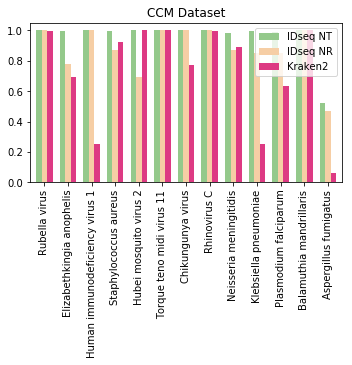

In [119]:
combined_results = pd.concat([idseq_species_results, pd.Series(species_correct).loc[idseq_species_results.index]], axis=1)
combined_results.columns = ['IDseq NT', 'IDseq NR', 'Kraken2']
names = ncbi.get_taxid_translator(list(combined_results.index))
print(names)
new_names = [names[int(i)] for i in combined_results.index]
combined_results.index = new_names

combined_results.plot(kind='bar', width=.7, figsize=(5,5), color=['#94C98B','#F6CEA5','#DD3A83'])
plt.tight_layout()
plt.title('CCM Dataset')
plt.savefig("S3A.pdf")

In [120]:
results_described = combined_results.describe()
print(results_described)
print(results_described.loc['50%']['IDseq NT'])
print("IDseq NT, median = " + str(results_described.loc['50%']['IDseq NT']) + ", IQR: " + 
     str(results_described.loc['25%']['IDseq NT']) + " - " + 
      str(results_described.loc['75%']['IDseq NT']))

print("IDseq NR, median = " + str(results_described.loc['50%']['IDseq NR']) + ", IQR: " + 
     str(results_described.loc['25%']['IDseq NR']) + " - " + 
      str(results_described.loc['75%']['IDseq NR']))

print("Kraken2, median = " + str(results_described.loc['50%']['Kraken2']) + ", IQR: " + 
     str(results_described.loc['25%']['Kraken2']) + " - " + 
      str(results_described.loc['75%']['Kraken2']))

import scipy
from scipy import stats
print("is NT significantly different than Kraken2?")
print(scipy.stats.wilcoxon(combined_results['IDseq NT'],combined_results['Kraken2']))

print("is NR significantly different than Kraken2?")
print(scipy.stats.wilcoxon(combined_results['IDseq NR'],combined_results['Kraken2']))

print("is NT significantly different than NR?")
print(scipy.stats.wilcoxon(combined_results['IDseq NR'],combined_results['IDseq NT']))



        IDseq NT   IDseq NR    Kraken2
count  13.000000  13.000000  13.000000
mean    0.959898   0.875900   0.729249
std     0.131080   0.157872   0.334297
min     0.524055   0.473245   0.061400
25%     0.994160   0.849811   0.635035
50%     1.000000   0.869456   0.894000
75%     1.000000   1.000000   0.996800
max     1.000000   1.000000   1.000000
1.0
IDseq NT, median = 1.0, IQR: 0.9941597139451728 - 1.0
IDseq NR, median = 0.8694563662374821, IQR: 0.8498112317130722 - 1.0
Kraken2, median = 0.894, IQR: 0.635035035035035 - 0.9968
is NT significantly different than Kraken2?
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
is NR significantly different than Kraken2?
WilcoxonResult(statistic=15.0, pvalue=0.1095109374886408)
is NT significantly different than NR?
WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)


/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
